# ResNet-34 PyTorch Starter Kit

- Updates:
  - added result for training with 400 epochs


- References (ResNet):
  - https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
  - https://arxiv.org/pdf/1512.03385.pdf
  
  
- Acknowledgements:
  - Original kernels: https://www.kaggle.com/hanjoonchoe/grapheme-resnet-18-n-l-inference-lb-0-8566 and https://www.kaggle.com/hanjoonchoe/grapheme-resnet-18-naive-learning-3
  
  
- Kindly upvote the kernel if you found it helpful, including the original author's!

# Part 1

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

# Any results you write to the current directory are saved as output.
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm_notebook as tqdm

In [11]:
train = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv')
data0 = pd.read_feather('/kaggle/usr/lib/resize-and-load-with-feather-format-much-faster/train_data_0.feather')
data1 = pd.read_feather('/kaggle/usr/lib/resize-and-load-with-feather-format-much-faster/train_data_1.feather')
data2 = pd.read_feather('/kaggle/usr/lib/resize-and-load-with-feather-format-much-faster/train_data_2.feather')
data3 = pd.read_feather('/kaggle/usr/lib/resize-and-load-with-feather-format-much-faster/train_data_3.feather')

In [12]:
ls /kaggle/usr/lib/resize-and-load-with-feather-format-much-faster

__notebook__.ipynb  custom.css           train_data_0.feather
__output__.json     test_data_0.feather  train_data_1.feather
__results__.html    test_data_1.feather  train_data_2.feather
__results___files/  test_data_2.feather  train_data_3.feather
__resultx__.html    test_data_3.feather


In [13]:
data_full = pd.concat([data0,data1,data2,data3],ignore_index=True)

In [14]:
class GraphemeDataset(Dataset):
    def __init__(self,df,label,_type='train'):
        self.df = df
        self.label = label
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        label1 = self.label.vowel_diacritic.values[idx]
        label2 = self.label.grapheme_root.values[idx]
        label3 = self.label.consonant_diacritic.values[idx]
        image = self.df.iloc[idx][1:].values.reshape(64,64).astype(np.float)
        return image,label1,label2,label3

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=False):
        super(ResidualBlock,self).__init__()
        self.cnn1 =nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels,kernel_size,1,padding,bias=False),
            nn.BatchNorm2d(out_channels)
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()
            
    def forward(self,x):
        residual = x
        x = self.cnn1(x)
        x = self.cnn2(x)
        x += self.shortcut(residual)
        x = nn.ReLU(True)(x)
        return x

## ResNet-18 Model

In [16]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18,self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=2,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        
        self.block2 = nn.Sequential(
            nn.MaxPool2d(1,1),
            ResidualBlock(64,64),
            ResidualBlock(64,64,2)
        )
        
        self.block3 = nn.Sequential(
            ResidualBlock(64,128),
            ResidualBlock(128,128,2)
        )
        
        self.block4 = nn.Sequential(
            ResidualBlock(128,256),
            ResidualBlock(256,256,2)
        )
        self.block5 = nn.Sequential(
            ResidualBlock(256,512),
            ResidualBlock(512,512,2)
        )
        
        self.avgpool = nn.AvgPool2d(2)
        # vowel_diacritic
        self.fc1 = nn.Linear(512,11)
        # grapheme_root
        self.fc2 = nn.Linear(512,168)
        # consonant_diacritic
        self.fc3 = nn.Linear(512,7)
        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        return x1,x2,x3

## ResNet34 Model

In [17]:
class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34,self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=2,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        
        self.block2 = nn.Sequential(
            nn.MaxPool2d(1,1),
            ResidualBlock(64,64),
            ResidualBlock(64,64,2)
        )
        
        self.block3 = nn.Sequential(
            ResidualBlock(64,128),
            ResidualBlock(128,128,2)
        )
        
        self.block4 = nn.Sequential(
            ResidualBlock(128,256),
            ResidualBlock(256,256,2)
        )
        self.block5 = nn.Sequential(
            ResidualBlock(256,512),
            ResidualBlock(512,512,2)
        )
        
        self.avgpool = nn.AvgPool2d(2)
        # vowel_diacritic
        self.fc1 = nn.Linear(512,11)
        # grapheme_root
        self.fc2 = nn.Linear(512,168)
        # consonant_diacritic
        self.fc3 = nn.Linear(512,7)
        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        return x1,x2,x3

## Remarks

- See previous version for torch summary as submission must not have internet enabled

In [18]:
#!pip install torchsummary
#from torchsummary import summary

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
#model_resnet34 = ResNet34().to(device)
#summary(model_resnet34, (1, 64, 64))

## Training Model

- We use ResNet34 and train for 50 epochs

In [21]:
model = ResNet34().to(device)
optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=4e-4)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=0.05)
criterion = nn.CrossEntropyLoss()
batch_size=32

In [22]:
epochs = 50 # original 50
model.train()
losses = []
accs = []
for epoch in range(epochs):
    reduced_index =train.groupby(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']).apply(lambda x: x.sample(5)).image_id.values
    reduced_train = train.loc[train.image_id.isin(reduced_index)]
    reduced_data = data_full.loc[data_full.image_id.isin(reduced_index)]
    train_image = GraphemeDataset(reduced_data,reduced_train)
    train_loader = torch.utils.data.DataLoader(train_image,batch_size=batch_size,shuffle=True)
    
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_acc = 0.0
    for idx, (inputs,labels1,labels2,labels3) in tqdm(enumerate(train_loader),total=len(train_loader)):
        inputs = inputs.to(device)
        labels1 = labels1.to(device)
        labels2 = labels2.to(device)
        labels3 = labels3.to(device)
        
        optimizer.zero_grad()
        outputs1,outputs2,outputs3 = model(inputs.unsqueeze(1).float())
        loss1 = criterion(outputs1,labels1)
        loss2 = criterion(outputs2,labels2)
        loss3 = criterion(outputs3,labels3)
        running_loss += loss1+loss2+loss3
        running_acc += (outputs1.argmax(1)==labels1).float().mean()
        running_acc += (outputs2.argmax(1)==labels2).float().mean()
        running_acc += (outputs3.argmax(1)==labels3).float().mean()
        (loss1+loss2+loss3).backward()
        optimizer.step()
    #scheduler.step()
    losses.append(running_loss/len(train_loader))
    accs.append(running_acc/(len(train_loader)*3))
    print('acc : {:.2f}%'.format(running_acc/(len(train_loader)*3)))
    print('loss : {:.4f}'.format(running_loss/len(train_loader)))
torch.save(model.state_dict(), 'resnet34_50epochs_saved_weights.pth')

epochs 1/50 


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



acc : 0.41%
loss : 7.0773
epochs 2/50 



acc : 0.49%
loss : 6.0436
epochs 3/50 



acc : 0.54%
loss : 5.3478
epochs 4/50 



acc : 0.58%
loss : 4.7767
epochs 5/50 



acc : 0.62%
loss : 4.1648
epochs 6/50 



acc : 0.65%
loss : 3.6196
epochs 7/50 



acc : 0.69%
loss : 3.1378
epochs 8/50 



acc : 0.73%
loss : 2.7442
epochs 9/50 



acc : 0.76%
loss : 2.4069
epochs 10/50 



acc : 0.78%
loss : 2.1926
epochs 11/50 



acc : 0.80%
loss : 1.9383
epochs 12/50 



acc : 0.81%
loss : 1.8307
epochs 13/50 



acc : 0.82%
loss : 1.7726
epochs 14/50 



acc : 0.84%
loss : 1.5884
epochs 15/50 



acc : 0.84%
loss : 1.5557
epochs 16/50 



acc : 0.85%
loss : 1.4678
epochs 17/50 



acc : 0.86%
loss : 1.3670
epochs 18/50 



acc : 0.86%
loss : 1.3510
epochs 19/50 



acc : 0.87%
loss : 1.2543
epochs 20/50 



acc : 0.88%
loss : 1.2023
epochs 21/50 



acc : 0.88%
loss : 1.1652
epochs 22/50 



acc : 0.89%
loss : 1.1142
epochs 23/50 



acc : 0.89%
loss : 1.1267
epochs 24/50 



acc : 0.89%
loss : 1.0867
epochs 25/50 



acc : 0.90%
loss : 0.9642
epochs 26/50 



acc : 0.90%
loss : 1.0020
epochs 27/50 



acc : 0.90%
loss : 0.9866
epochs 28/50 



acc : 0.90%
loss : 0.9882
epochs 29/50 



acc : 0.91%
loss : 0.9383
epochs 30/50 



acc : 0.91%
loss : 0.9139
epochs 31/50 



acc : 0.91%
loss : 0.8890
epochs 32/50 



acc : 0.91%
loss : 0.8644
epochs 33/50 



acc : 0.91%
loss : 0.8484
epochs 34/50 



acc : 0.92%
loss : 0.7885
epochs 35/50 



acc : 0.92%
loss : 0.8203
epochs 36/50 



acc : 0.91%
loss : 0.8440
epochs 37/50 



acc : 0.92%
loss : 0.7778
epochs 38/50 



acc : 0.92%
loss : 0.8024
epochs 39/50 



acc : 0.92%
loss : 0.7656
epochs 40/50 



acc : 0.92%
loss : 0.7406
epochs 41/50 



acc : 0.92%
loss : 0.7489
epochs 42/50 



acc : 0.93%
loss : 0.6988
epochs 43/50 



acc : 0.93%
loss : 0.7348
epochs 44/50 



acc : 0.93%
loss : 0.6953
epochs 45/50 



acc : 0.93%
loss : 0.6709
epochs 46/50 



acc : 0.93%
loss : 0.6639
epochs 47/50 



acc : 0.93%
loss : 0.6659
epochs 48/50 



acc : 0.93%
loss : 0.6582
epochs 49/50 



acc : 0.94%
loss : 0.6291
epochs 50/50 



acc : 0.94%
loss : 0.6439


Text(0.5, 1.0, 'acc')

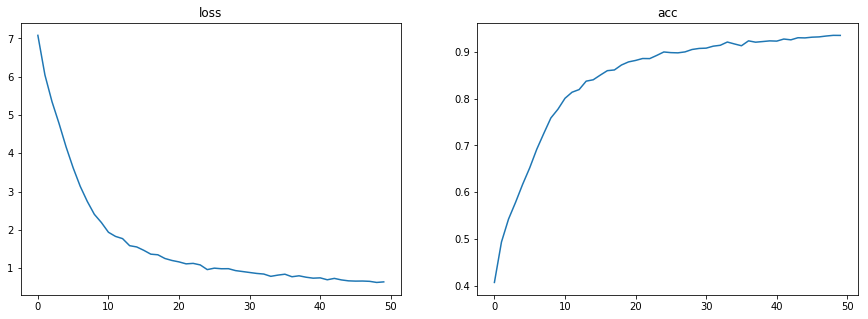

In [23]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(losses)
ax[0].set_title('loss')
ax[1].plot(accs)
ax[1].set_title('acc')

# Part 2

In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm_notebook as tqdm

/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_multi_diacritics.csv
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_0.parquet
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train.csv
/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/class_map_corrected.csv
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet
/kaggle/input/trained400/resnet34_400epochs_saved_weights.pth
/kaggle/input/grapheme-resnet-18-naive-learning-2/__results__.html
/kaggle/input/grapheme-resnet-18-naive-learning-2/saved_weights.pth
/kaggle/input/grapheme-resnet-18-naive-learning-2/__resultx__.html
/kaggle/inpu

In [25]:
test = pd.read_csv('/kaggle/input/bengaliai-cv19/test.csv')

In [26]:
class GraphemeDataset(Dataset):
    def __init__(self,df,_type='train'):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        image = self.df.iloc[idx][1:].values.reshape(64,64).astype(float)
        return image

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet34().to(device)
model.load_state_dict(torch.load('/kaggle/input/trained400/resnet34_400epochs_saved_weights.pth'))

<All keys matched successfully>

In [28]:
def Resize(df,size=64):
    resized = {} 
    df = df.set_index('image_id')
    for i in tqdm(range(df.shape[0])):
        image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size))
        resized[df.index[i]] = image.reshape(-1)
    resized = pd.DataFrame(resized).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized

In [29]:
model.eval()
test_data = ['test_image_data_0.parquet','test_image_data_1.parquet','test_image_data_2.parquet','test_image_data_3.parquet']
predictions = []
batch_size=1
for fname in test_data:
    data = pd.read_parquet(f'/kaggle/input/bengaliai-cv19/{fname}')
    data = Resize(data)
    test_image = GraphemeDataset(data)
    test_loader = torch.utils.data.DataLoader(test_image,batch_size=1,shuffle=False)
    with torch.no_grad():
        for idx, (inputs) in tqdm(enumerate(test_loader),total=len(test_loader)):
            inputs.to(device)
            
            outputs1,outputs2,outputs3 = model(inputs.unsqueeze(1).float().cuda())
            predictions.append(outputs3.argmax(1).cpu().detach().numpy())
            predictions.append(outputs2.argmax(1).cpu().detach().numpy())
            predictions.append(outputs1.argmax(1).cpu().detach().numpy())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


# Save Results

In [30]:
submission = pd.read_csv('/kaggle/input/bengaliai-cv19/sample_submission.csv')

In [31]:
submission.target = np.hstack(predictions)
submission.head(10)

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,93
5,Test_1_vowel_diacritic,2
6,Test_2_consonant_diacritic,0
7,Test_2_grapheme_root,19
8,Test_2_vowel_diacritic,0
9,Test_3_consonant_diacritic,0


In [32]:
submission.to_csv('submission.csv',index=False)